In [33]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input

tf.__version__

'2.0.0'

In [64]:
# hyperparameter 
lr = 1e-4
decay = 1e-2
batch_size = 50
epochs = 100

val_set_size_percentage = 10
test_set_size_percentage = 10

In [26]:
df = pd.read_csv('downjone5y.csv')

In [27]:

df = df.drop('Adj Close', axis=1)
df

,Date,Open,High,Low,Close,Volume
0,2014-10-31,17208.779297,17395.539063,17208.779297,17390.519531,121610000
1,2014-11-03,17390.900391,17410.650391,17339.849609,17366.240234,80030000
2,2014-11-04,17368.810547,17397.230469,17278.359375,17383.839844,81390000
3,2014-11-05,17385.759766,17486.589844,17385.759766,17484.529297,76030000
4,2014-11-06,17491.660156,17560.310547,17440.349609,17554.470703,70670000
5,2014-11-07,17558.580078,17575.330078,17493.369141,17573.929688,82860000
6,2014-11-10,17568.980469,17621.869141,17547.509766,17613.740234,71430000
7,2014-11-11,17615.640625,17638.210938,17584.939453,17614.900391,52880000
8,2014-11-12,17604.750000,17626.710938,17536.169922,17612.199219,75980000
9,2014-11-13,17618.689453,17705.480469,17583.880859,17652.789063,80540000


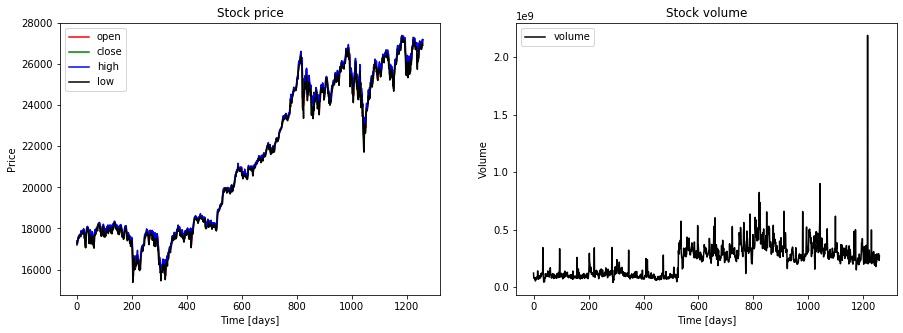

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(df['Open'], color='red', label='open')
plt.plot(df['Close'], color='green', label='close')
plt.plot(df['High'], color='blue', label='high')
plt.plot(df['Low'], color='black', label='low')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.plot(df['Volume'], color='black', label='volume')
plt.title('Stock volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

In [29]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].to_numpy().reshape(-1, 1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].to_numpy().reshape(-1, 1))    
    df['High'] = min_max_scaler.fit_transform(df['High'].to_numpy().reshape(-1, 1))    
    df['Close'] = min_max_scaler.fit_transform(df['Close'].to_numpy().reshape(-1, 1))    
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [30]:
df_index = df.drop('Volume', axis=1)
df_index = df_index.drop('Date', axis=1)

cols = list(df_index.columns.values)
print('Col : ', cols)

# normalize index
df_index_norm = normalize_data(df_index)

# split train, val, test data
seq_len = 20
x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close']
x_train.shape =  (991, 19, 4)
y_train.shape =  (991, 4)
x_val.shape =  (124, 19, 4)
y_val.shape =  (124, 4)
x_test.shape =  (124, 19, 4)
y_test.shape =  (124, 4)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


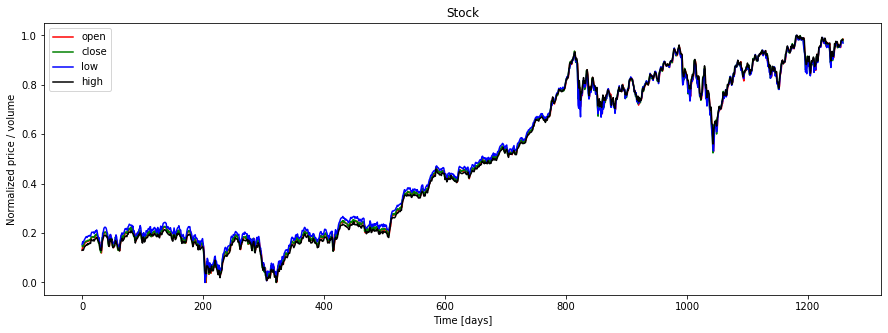

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(df_index_norm['Open'], color='red', label='open')
plt.plot(df_index_norm['Close'], color='green', label='close')
plt.plot(df_index_norm['Low'], color='blue', label='low')
plt.plot(df_index_norm['High'], color='black', label='high')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [73]:
n_steps = seq_len - 1

# input_feed = Input(shape=(19, 4))
# x = LSTM(200, return_sequences=True)(x)
# prediction = Dense(4)(x)

# model = Model(inputs=input_feed, outputs=prediction)

model = Sequential([
    LSTM(200, input_shape=(19,4), activation='relu', return_sequences=True),
    LSTM(200, activation='relu', dropout=0.2),
    Dense(4)
])

model.compile(optimizer=Adam(lr=lr, decay=decay),
             loss='mse', metrics=['mse'])

model.summary()
model.fit(x_train, y_train, epochs=epochs, verbose=1,
         batch_size=batch_size, validation_data=(x_val, y_val))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 19, 200)           164000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 804       
Total params: 485,604
Trainable params: 485,604
Non-trainable params: 0
_________________________________________________________________
Train on 991 samples, validate on 124 samples
Epoch 1/100
991/991 [==============================] - 6s 6ms/sample - loss: 0.2126 - mse: 0.2126 - val_loss: 0.5280 - val_mse: 0.5280
Epoch 2/100
991/991 [==============================] - 2s 2ms/sample - loss: 0.1510 - mse: 0.1510 - val_loss: 0.3164 - val_mse: 0.3164
Epoch 3/100
991/991 [==============================] - 3s 3ms

KeyboardInterrupt: 

In [69]:
x_train.shape
y_train.shape

(991, 4)

In [70]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

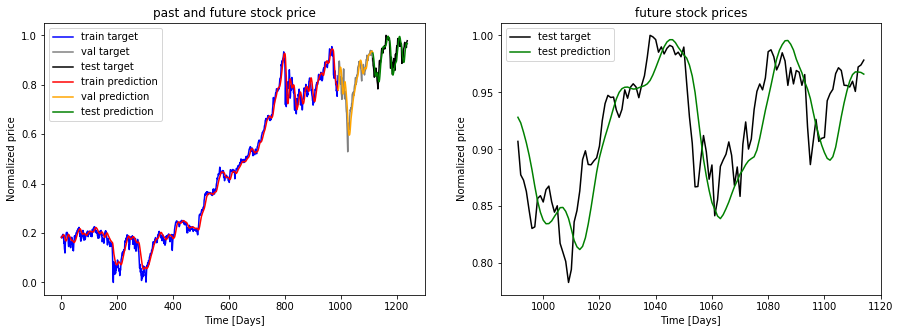

In [71]:
ft = 0
 
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
         color='gray', label='val target')
plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
        y_test[:, ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
        color='red', label='train prediction') 
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
        y_val_pred[:, ft], color='orange', label='val prediction')
plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
        y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
        y_test_pred[:, ft], color ='green', label='test prediction')
plt.title('past and future stock price')
plt.xlabel('Time [Days]')
plt.ylabel('Normalized price')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
        y_test[:, ft], color='black', label='test target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
        y_test_pred[:, ft], color='green', label='test prediction')
plt.title('future stock prices')
plt.xlabel('Time [Days]')
plt.ylabel('Normalized price')
plt.legend(loc='best')

